In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
threads = 16

In [6]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp})
    model.link_to_cpp(force_compile=do_compile)

# Solve and simulate from alternative models

In [7]:
# settings for models to solve
T = 10
num_power = 51
num_love = 101
specs = {
    'model 1':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
    'model 2':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'do_cpp':do_cpp,'threads':threads}},
    'model 3':{'latexname':'$\sigma_{\psi}=0.04 +$', 'par':{'sigma_love':0.04,'T':T,'num_love':num_love,'do_cpp':do_cpp,'threads':threads}},
#     'model 4':{'latexname':'$\sigma_{\psi}=0.04 ++$', 'par':{'sigma_love':0.04,'T':T,'num_love':num_love*2,'do_cpp':do_cpp,'threads':threads}},
    # 'model 4':{'latexname':'$\sigma_{\psi}=0.04 +love$', 'par':{'sigma_love':0.04,'T':T,'num_love':100,'num_power':21,'do_cpp':do_cpp,'threads':threads}},
    # 'model 5':{'latexname':'$\sigma_{\psi}=0.04 +power$', 'par':{'sigma_love':0.04,'T':T,'num_love':21,'num_power':100,'do_cpp':do_cpp,'threads':threads}},
    # 'model 2':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 4':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'threads':threads}},
}

In [8]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()

solving model 1...
solving model 2...
solving model 3...


# Simulated paths

Wall time: 18.4 ms
Wall time: 6.5 ms
Wall time: 8.53 ms
Wall time: 8 ms
Wall time: 9.07 ms
Wall time: 8.41 ms


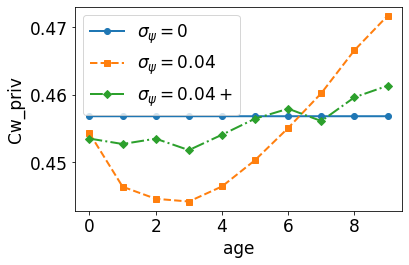

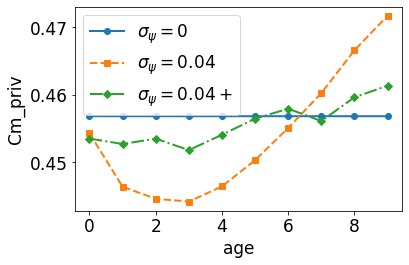

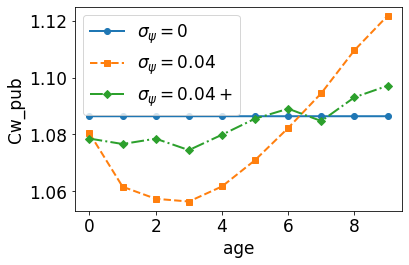

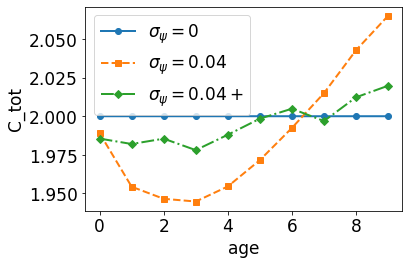

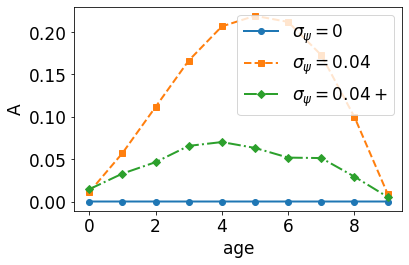

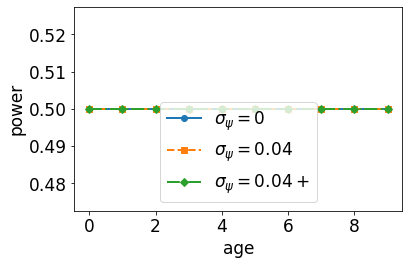

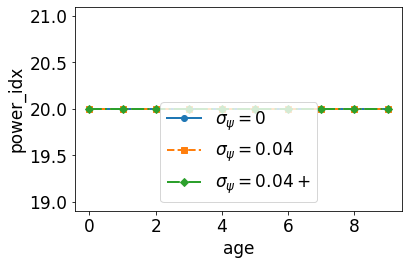

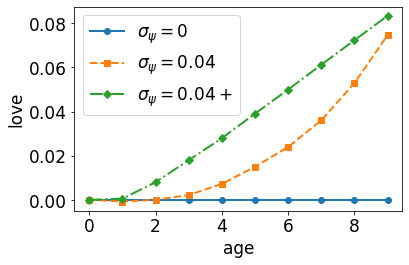

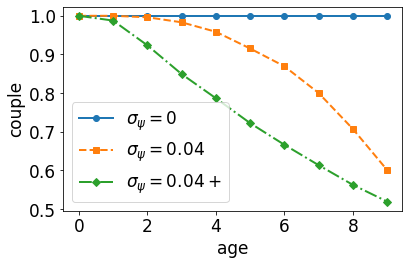

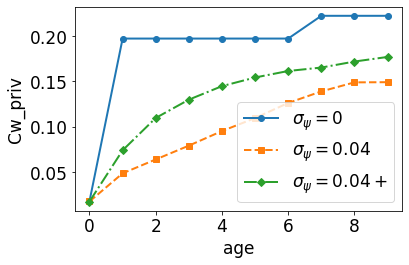

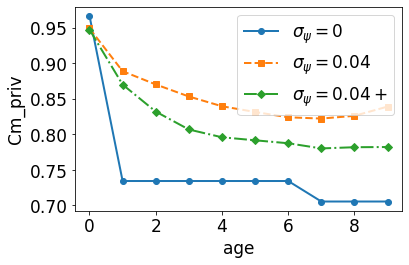

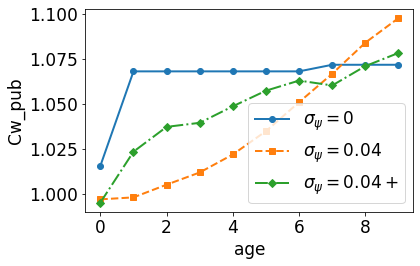

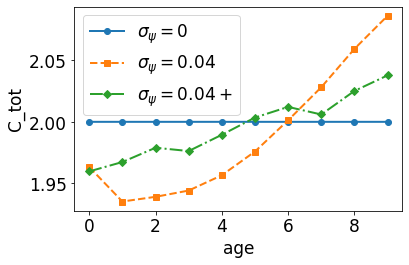

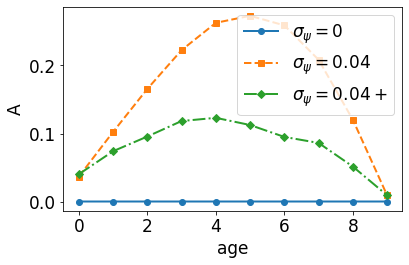

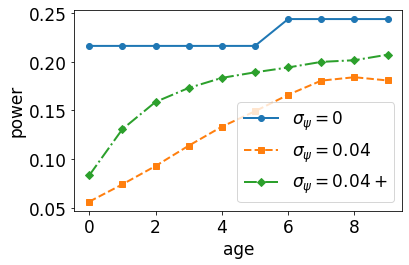

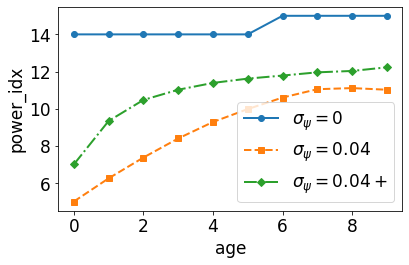

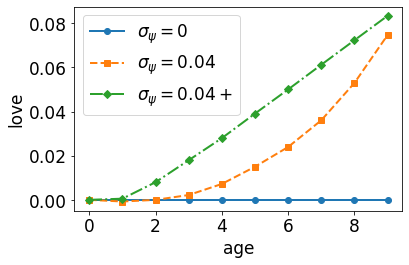

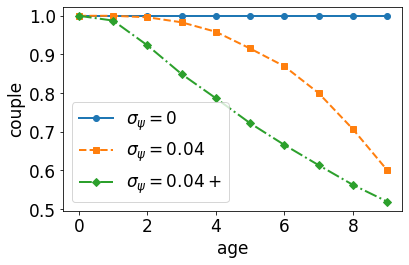

In [9]:
#TODO: save the transition into singlehood as something. Basically just equal to value of single here.
#TODO: update check_participation_constraints setup

var_list = ('Cw_priv','Cm_priv','Cw_pub','C_tot','A','power','power_idx','love','couple')

# (np.abs(a - 1.9)).argmin()
for init_power_idx in (20,2): #(20,): #(1,10):
    for init_love in (0.0,): #(0.0,0.2): 

            for i,name in enumerate(specs.keys()):
                model = models[name]

                # show how starting of in a low bargaining power gradually improves
                model.sim.init_power_idx[:] = init_power_idx
                model.sim.init_love[:] = init_love 
                %time model.simulate()
                
            for var in var_list:

                fig, ax = plt.subplots()
                
                for i,name in enumerate(specs.keys()):
                    model = models[name]

                    # pick out couples (if not the share of couples is plotted)
                    if var == 'couple':
                        nan = 0.0
                    else:
                        I = model.sim.couple<1
                        nan = np.zeros(I.shape)
                        nan[I] = np.nan

                    # pick relevant variable for couples
                    y = getattr(model.sim,var)        
                    y = np.nanmean(y + nan,axis=0)

                    ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
                    ax.set(xlabel='age',ylabel=f'{var}');

                plt.legend()

                fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
                plt.tight_layout()
                plt.savefig(path+fig_name+'.pdf')
                
# Wall time: 11.8 ms
# Wall time: 8.25 ms
# Wall time: 7.81 ms
# Wall time: 8.08 ms
# Wall time: 11.7 ms
# Wall time: 11.3 ms

In [ ]:
stop
# old...
# (np.abs(a - 1.9)).argmin()
for init_power_idx in (20,): #(20,): #(1,10):
    for init_love in (0.0,): #(0.0,0.2): 

        for var in ('Cw_priv','Cm_priv','Cw_pub','C_tot','A','power','power_idx','love','couple'):

            fig, ax = plt.subplots()

            for i,name in enumerate(specs.keys()):
                model = models[name]

                # show how starting of in a low bargaining power gradually improves
                model.sim.init_power_idx[:] = init_power_idx
                model.sim.init_love[:] = init_love 
                model.simulate()

                # pick out couples (if not the share of couples is plotted)
                if var == 'couple':
                    nan = 0.0
                else:
                    I = model.sim.couple<1
                    nan = np.zeros(I.shape)
                    nan[I] = np.nan

                # pick relevant variable for couples
                y = getattr(model.sim,var)        
                y = np.nanmean(y + nan,axis=0)

                ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
                ax.set(xlabel='age',ylabel=f'{var}');

            plt.legend()

            fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
            plt.tight_layout()
            plt.savefig(path+fig_name+'.pdf')

In [ ]:
# interplation of index: Seems ok (bit wierd difference)
# try more corret interpolation approach!!! 
#    interpolate value of being single and value of being a couple. And then do the entire opdating scheme in the simulation again...    

In [ ]:
stop

In [ ]:
np.nanmax(models['model 2'].sim.C_tot,axis=0)

# Policy functions

In [ ]:
cmaps = ('viridis','gray')

t =  0 #0 #par.T-1 - 1 
iL = 5 

par = models['model 1'].par
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for power_idx in (10,): #(1,10):'model 1'].
    for iL in (5,): #(0.0,0.2): 

        for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

            fig = plt.figure()
            ax = plt.axes(projection='3d')

            for i,name in enumerate(specs.keys()):
                model = models[name]
                
                if var == 'power':
                    power_idx = model.sol.power_idx[t,:,iL,:]
                    Z = par.grid_power[power_idx] # if negative-> divorce. Then this wouldn't work

                    Z[power_idx<0] = -9210.
                else:
                    Z = getattr(model.sol,var)[t,:,iL,:]

                ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                                cmap=cmaps[i], edgecolor='none',alpha=0.5);
                ax.set(xlabel='power (woman)',ylabel='wealth',title=f'{var}');

In [ ]:
# TODO: 
# 1. check when parameters change..
# WHY ARE THEY NOT OVERLAPPING when sigma_love=0.1!!? I think it must have to do with the very steep slope in the bottom and the grid spacing
# yes: that is why

sol = model.sol
par = model.par
t =  0 #0 #par.T-1 - 1 
iL = 5 # for negative shocks (iL<5), the relationship is doomed..

for iA in [0,10,30]:
    plt.plot(par.grid_power,sol.Vw_couple[t,:,iL,iA]);
    plt.plot(par.grid_power,np.ones(par.grid_power.size)*sol.Vw_single[t,iA]); # the slight difference is from the discrete power grid
    
#     plt.plot(par.grid_power,par.grid_power[sol.power_idx[t,:,iL,iA]],marker='.')
#     plt.plot(par.grid_power,par.grid_power,linestyle='--')

In [ ]:


t = par.T-4
iL = 5
X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if var == 'power':
        power_idx = sol.power_idx[t,:,iL,:]
        Z = par.grid_power[power_idx] # if negative-> divorce. Then this wouldn't work
        
        Z[power_idx<0] = -9210.
    else:
        Z = getattr(sol,var)[t,:,iL,:]

    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none');
    ax.set(xlabel='power (woman)',ylabel='wealth',title=f'{var}');

In [ ]:
# plot as a function of love and wealth
t = par.T-4
iP = 10
X, Y = np.meshgrid(par.grid_love, par.grid_A,indexing='ij')

for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if var == 'power':
        power_idx = sol.power_idx[t,iP,:,:]
        Z = par.grid_power[power_idx] # if negative-> divorce. Then this wouldn't work
        
        Z[power_idx<0] = -9210.
    else:
        Z = getattr(sol,var)[t,iP,:,:]

    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none');
    ax.set(xlabel='love',ylabel='wealth',title=f'{var}');

In [ ]:
# plot as a function of power and love 
t = par.T-4
iA = 10
X, Y = np.meshgrid(par.grid_power, par.grid_love,indexing='ij')

for var in ('Vw_couple','Vm_couple','Cw_priv_couple','Cm_priv_couple','C_pub_couple','power'):

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if var == 'power':
        power_idx = sol.power_idx[t,:,:,iA]
        Z = par.grid_power[power_idx] # if negative-> divorce. Then this wouldn't work
        
        Z[power_idx<0] = -9210.
    else:
        Z = getattr(sol,var)[t,:,:,iA]

    ax.plot_surface(X, Y, Z,rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none');
    ax.set(xlabel='power',ylabel='love',title=f'{var}');

In [ ]:
# %lprun -f model.value_of_choice_couple -f brg.util -f model.indiv_value_of_choice_couple model.solve()

In [ ]:
model_name = 'model 1'
model = models[model_name]

# show how starting of in a low bargaining power gradually improves
model.sim.init_power_idx[:] = 1
model.sim.init_love[:] = 0.2 # interesting difference: 0.0 vs 0.2   [with sigma_love=0.0]
model.simulate()

for var in ('Cw_priv','Cm_priv','Cw_pub','C_tot','A','power','love','couple'):

    fig, ax = plt.subplots()
    
    if var == 'C_tot':
        C_tot = model.sim.Cw_priv + model.sim.Cm_priv + model.sim.Cw_pub
        y = np.nanmean(C_tot,axis=0)
    else:
        y = np.nanmean(getattr(model.sim,var),axis=0)

    ax.plot(y,marker='.');
    ax.set(xlabel='age',ylabel=f'{var}');